# Geometric ML Interactive Cookbook

**A complete interactive guide: data → graph → metric → topology → stats → dynamics**

This notebook demonstrates the full pipeline of the geometric ML library with live code examples, visualizations, and interactive exploration.

## Table of Contents
1. [Setup & Environment](#setup)
2. [Data Preparation](#data)
3. [Graph Construction](#graphs)
4. [Metric Design](#metrics)
5. [Topology Selection](#topology)
6. [Statistical Analysis](#stats)
7. [Dynamics & Geodesics](#dynamics)
8. [Complete Pipeline Demo](#pipeline)
9. [Interactive Exploration](#interactive)

## 1. Setup & Environment {#setup}

First, let's set up our environment and import all necessary modules.

In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown
import warnings
warnings.filterwarnings('ignore')

# Set up paths for local development
import sys
sys.path.insert(0, '../src')

# Geometric ML modules
from validation.reproducibility import ensure_reproducibility, compute_data_hash
from validation.numerical import validate_float64_precision
from graphs.knn import build_graph
from graphs.laplacian import laplacian
from validation.mathematical import check_graph_connectivity
from solvers.lanczos import topk_eigs
from stats.spectra import spectral_gap, spectral_entropy
from topology import (
    create_topology, TopologyType, get_orientability_pairs,
    integrate_geodesic, comprehensive_topology_validation
)

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Ensure reproducibility
ensure_reproducibility(42)

print("🚀 Geometric ML Environment Ready!")
print("📊 All modules imported successfully")
print("🔒 Reproducibility ensured with seed=42")

🚀 Geometric ML Environment Ready!
📊 All modules imported successfully
🔒 Reproducibility ensured with seed=42


## 2. Data Preparation {#data}

Let's start by generating and exploring our data.

In [2]:
def generate_manifold_data(n_samples=800, manifold_type='sphere', noise_level=0.1):
    """Generate data lying on various manifolds."""
    rng = np.random.default_rng(42)
    
    if manifold_type == 'sphere':
        # Data on noisy sphere
        theta = rng.uniform(0, 2*np.pi, n_samples)
        phi = rng.uniform(0, np.pi, n_samples)
        
        X = np.column_stack([
            np.sin(phi) * np.cos(theta),
            np.sin(phi) * np.sin(theta), 
            np.cos(phi)
        ])
        
        # Add noise and embed in higher dimensions
        noise = rng.normal(0, noise_level, (n_samples, 3))
        X += noise
        
        # Embed in 8D
        X_embedded = np.column_stack([
            X,
            rng.normal(0, noise_level/2, (n_samples, 5))
        ])
        
        return X_embedded, theta, phi
        
    elif manifold_type == 'swiss_roll':
        # Swiss roll manifold
        t = rng.uniform(1.5*np.pi, 4.5*np.pi, n_samples)
        height = rng.uniform(0, 10, n_samples)
        
        X = np.column_stack([
            t * np.cos(t),
            height,
            t * np.sin(t)
        ])
        
        # Add noise and embed
        noise = rng.normal(0, noise_level, (n_samples, 3))
        X += noise
        
        X_embedded = np.column_stack([
            X,
            rng.normal(0, noise_level/2, (n_samples, 5))
        ])
        
        return X_embedded, t, height
        
    elif manifold_type == 'mobius':
        # Möbius-like structure
        u = rng.uniform(0, 2*np.pi, n_samples)
        v = rng.uniform(-1, 1, n_samples)
        
        # Möbius strip parametrization
        X = np.column_stack([
            (1 + v/2 * np.cos(u/2)) * np.cos(u),
            (1 + v/2 * np.cos(u/2)) * np.sin(u),
            v/2 * np.sin(u/2)
        ])
        
        # Add noise and embed
        noise = rng.normal(0, noise_level, (n_samples, 3))
        X += noise
        
        X_embedded = np.column_stack([
            X,
            rng.normal(0, noise_level/2, (n_samples, 5))
        ])
        
        return X_embedded, u, v

# Generate different types of data
manifold_types = ['sphere', 'swiss_roll', 'mobius']
datasets = {}

for manifold in manifold_types:
    X, param1, param2 = generate_manifold_data(n_samples=600, manifold_type=manifold)
    datasets[manifold] = {'X': X, 'param1': param1, 'param2': param2}
    print(f"Generated {manifold} data: {X.shape}")

print(f"\n📊 Created {len(datasets)} datasets")

Generated sphere data: (600, 8)
Generated swiss_roll data: (600, 8)
Generated mobius data: (600, 8)

📊 Created 3 datasets


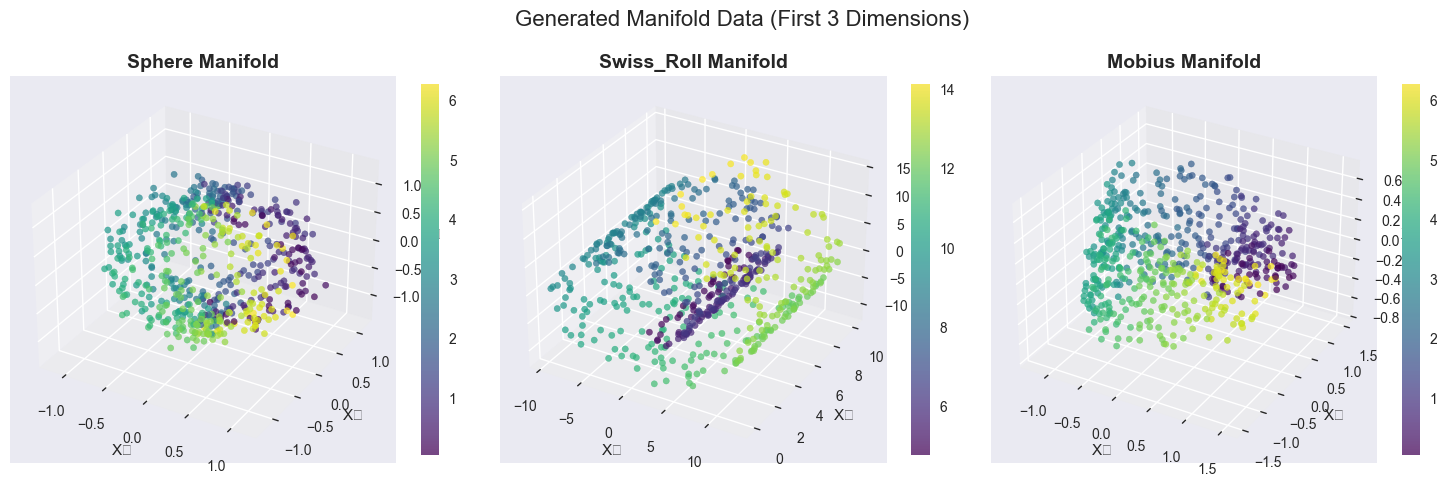


🔍 Data Validation:
  sphere: hash=a7bcd0212a31..., precision=✓
  swiss_roll: hash=7bd4f1a8e1c2..., precision=✓
  mobius: hash=6e2ed914ac9f..., precision=✓


In [3]:
# Visualize the datasets
fig = plt.figure(figsize=(15, 5))

for i, (name, data) in enumerate(datasets.items()):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    X = data['X']
    param1 = data['param1']
    
    # Plot first 3 dimensions, colored by first parameter
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], 
                        c=param1, cmap='viridis', s=20, alpha=0.7)
    
    ax.set_title(f'{name.title()} Manifold', fontsize=14, fontweight='bold')
    ax.set_xlabel('X₁')
    ax.set_ylabel('X₂')
    ax.set_zlabel('X₃')
    
    plt.colorbar(scatter, ax=ax, shrink=0.8)

plt.tight_layout()
plt.suptitle('Generated Manifold Data (First 3 Dimensions)', fontsize=16, y=1.02)
plt.show()

# Data validation
print("\n🔍 Data Validation:")
for name, data in datasets.items():
    X = data['X']
    data_hash = compute_data_hash(X)
    precision_check = validate_float64_precision({name: X})
    
    print(f"  {name}: hash={data_hash[:12]}..., precision={'✓' if precision_check['precision_adequate'] else '✗'}")

## 3. Graph Construction {#graphs}

Build k-NN graphs with dual transport modes and analyze connectivity.

In [4]:
def build_dual_transport_graphs(X, k=16):
    """Build both additive and multiplicative transport graphs."""
    
    print(f"🔗 Building k-NN graphs with k={k}")
    
    # Additive transport (Gaussian)
    print("  📊 Additive transport...")
    G_add = build_graph(X, mode="additive", k=k, sigma="median", seed=42)
    L_add = laplacian(G_add, normalized=True)
    
    # Multiplicative transport (Poisson via log/Haar)
    print("  📈 Multiplicative transport...")
    G_mult = build_graph(X, mode="multiplicative", k=k, tau="median", eps=1e-6, seed=42)
    L_mult = laplacian(G_mult, normalized=True)
    
    # Connectivity analysis
    conn_add = check_graph_connectivity(G_add, require_connected=False)
    conn_mult = check_graph_connectivity(G_mult, require_connected=False)
    
    print(f"  ✓ Additive graph connected: {conn_add}")
    print(f"  ✓ Multiplicative graph connected: {conn_mult}")
    
    return {
        'G_additive': G_add,
        'G_multiplicative': G_mult,
        'L_additive': L_add,
        'L_multiplicative': L_mult,
        'connected_add': conn_add,
        'connected_mult': conn_mult
    }

# Build graphs for all datasets
graph_results = {}
for name, data in datasets.items():
    print(f"\n--- {name.upper()} ---")
    graph_results[name] = build_dual_transport_graphs(data['X'], k=16)

print("\n🎯 Graph construction complete!")


--- SPHERE ---
🔗 Building k-NN graphs with k=16
  📊 Additive transport...
  📈 Multiplicative transport...
  ✓ Additive graph connected: True
  ✓ Multiplicative graph connected: True

--- SWISS_ROLL ---
🔗 Building k-NN graphs with k=16
  📊 Additive transport...
  📈 Multiplicative transport...
  ✓ Additive graph connected: True
  ✓ Multiplicative graph connected: True

--- MOBIUS ---
🔗 Building k-NN graphs with k=16
  📊 Additive transport...
  📈 Multiplicative transport...
  ✓ Additive graph connected: True
  ✓ Multiplicative graph connected: True

🎯 Graph construction complete!


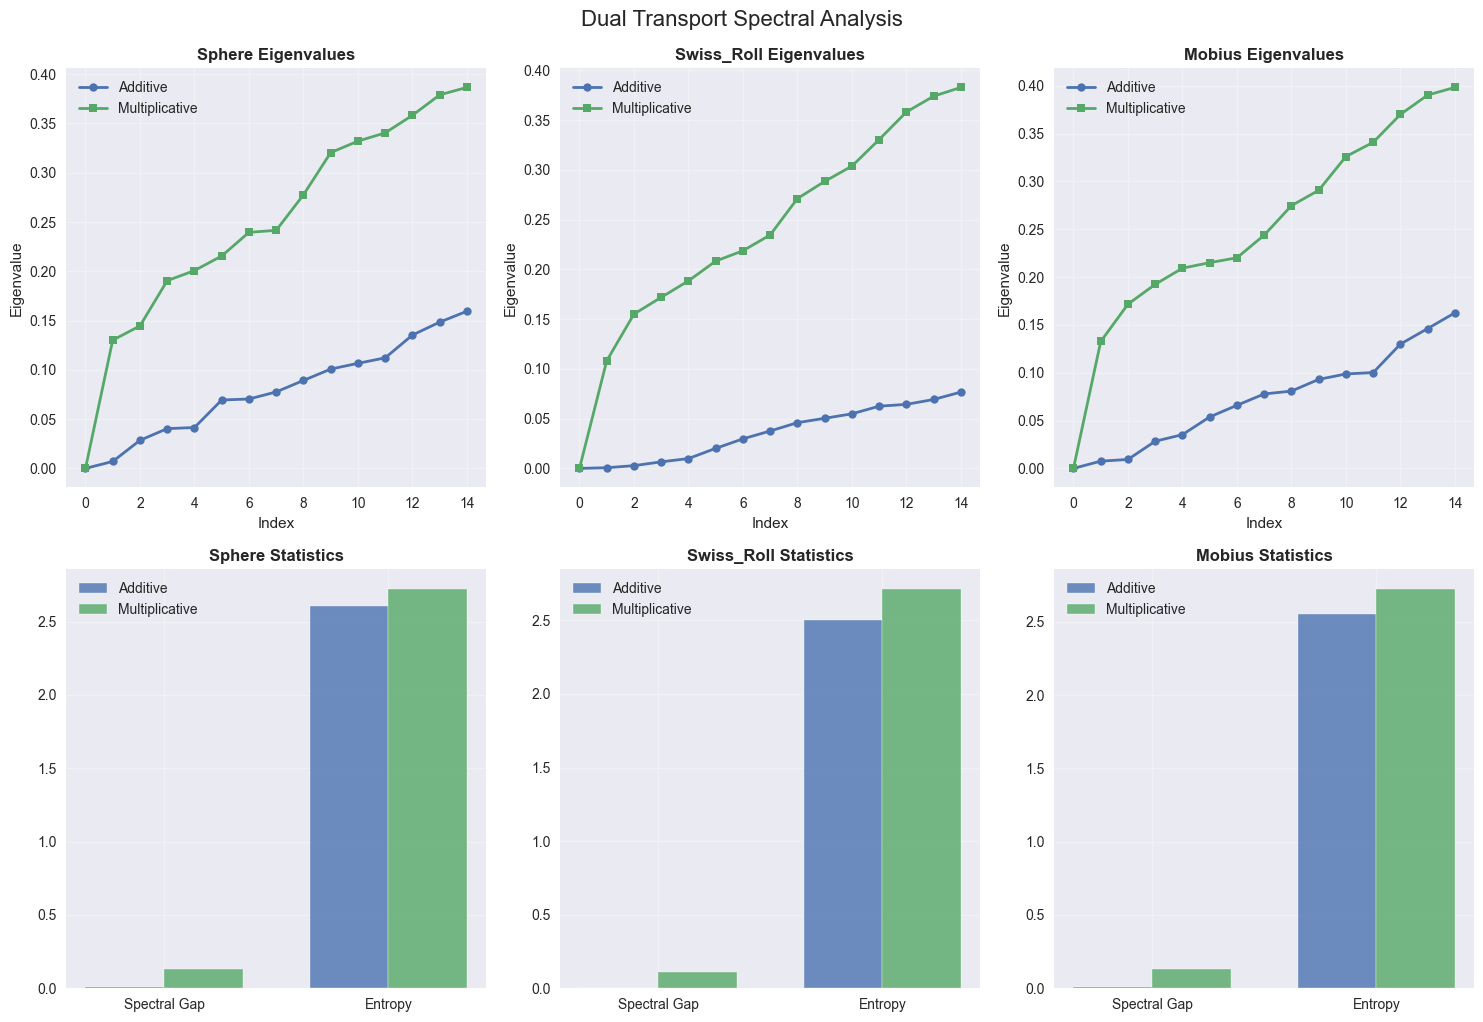


📊 Spectral Analysis Summary:
Dataset     | Transport      | Gap    | Entropy
---------------------------------------------
sphere      | Additive       | 0.0070 | 2.6063
            | Multiplicative | 0.1302 | 2.7209
---------------------------------------------
swiss_roll  | Additive       | 0.0007 | 2.4996
            | Multiplicative | 0.1081 | 2.7125
---------------------------------------------
mobius      | Additive       | 0.0076 | 2.5565
            | Multiplicative | 0.1326 | 2.7232
---------------------------------------------


In [5]:
# Analyze graph properties
def analyze_graph_properties(graphs, name):
    """Analyze and visualize graph properties."""
    
    L_add = graphs['L_additive']
    L_mult = graphs['L_multiplicative']
    
    # Compute spectra
    eigenvals_add, _,_ = topk_eigs(L_add, k=20, which="SM")
    eigenvals_mult, _, _ = topk_eigs(L_mult, k=20, which="SM")
    
    # Compute spectral statistics
    gap_add = spectral_gap(L_add)
    gap_mult = spectral_gap(L_mult)
    
    entropy_add = spectral_entropy(L_add, k=16)
    entropy_mult = spectral_entropy(L_mult, k=16)
    
    return {
        'eigenvals_add': eigenvals_add,
        'eigenvals_mult': eigenvals_mult,
        'gap_add': gap_add,
        'gap_mult': gap_mult,
        'entropy_add': entropy_add,
        'entropy_mult': entropy_mult
    }

# Analyze all datasets
spectral_results = {}
for name, graphs in graph_results.items():
    spectral_results[name] = analyze_graph_properties(graphs, name)

# Create comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (name, results) in enumerate(spectral_results.items()):
    # Eigenvalue spectra
    ax1 = axes[0, i]
    ax1.plot(results['eigenvals_add'][:15], 'o-', label='Additive', linewidth=2, markersize=6)
    ax1.plot(results['eigenvals_mult'][:15], 's-', label='Multiplicative', linewidth=2, markersize=6)
    ax1.set_title(f'{name.title()} Eigenvalues', fontweight='bold')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Eigenvalue')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Statistics comparison
    ax2 = axes[1, i]
    stats_add = [results['gap_add'], results['entropy_add']]
    stats_mult = [results['gap_mult'], results['entropy_mult']]
    
    x = np.arange(2)
    width = 0.35
    
    ax2.bar(x - width/2, stats_add, width, label='Additive', alpha=0.8)
    ax2.bar(x + width/2, stats_mult, width, label='Multiplicative', alpha=0.8)
    
    ax2.set_title(f'{name.title()} Statistics', fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Spectral Gap', 'Entropy'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Dual Transport Spectral Analysis', fontsize=16, y=1.02)
plt.show()

# Print summary
print("\n📊 Spectral Analysis Summary:")
print("Dataset     | Transport      | Gap    | Entropy")
print("-" * 45)
for name, results in spectral_results.items():
    print(f"{name:<11} | Additive       | {results['gap_add']:.4f} | {results['entropy_add']:.4f}")
    print(f"{'':<11} | Multiplicative | {results['gap_mult']:.4f} | {results['entropy_mult']:.4f}")
    print("-" * 45)

## 4. Metric Design {#metrics}

Design Fisher-Rao pullback metrics and validate seam compatibility.

In [6]:
def create_fisher_rao_metric(X, alpha=0.5, data_influence=True):
    """Create Fisher-Rao-inspired pullback metric."""
    
    def metric_fn(q):
        u, v = q[0], q[1]
        
        if data_influence:
            # Incorporate data structure
            data_term = np.exp(-0.2 * (u**2 + v**2))
            spatial_var = 0.3 * np.sin(2*u) * np.cos(2*v)
        else:
            data_term = 1.0
            spatial_var = 0.0
        
        # Seam-compatible components
        g11 = 1.0 + alpha * data_term + 0.2 * np.cos(2*v)  # Even in v
        g22 = 0.8 + alpha * data_term * 0.7 + 0.1 * np.cos(4*v)  # Even in v
        g12 = 0.1 * alpha * np.sin(2*u) * np.sin(2*v)  # Odd in v, π-periodic in u
        
        return np.array([[g11, g12], [g12, g22]])
    
    def metric_grad_fn(q):
        """Compute metric gradient via finite differences."""
        h = 1e-6
        g_base = metric_fn(q)
        
        # ∂g/∂u
        g_u_plus = metric_fn(q + np.array([h, 0]))
        du_g = (g_u_plus - g_base) / h
        
        # ∂g/∂v
        g_v_plus = metric_fn(q + np.array([0, h]))
        dv_g = (g_v_plus - g_base) / h
        
        return du_g, dv_g
    
    return metric_fn, metric_grad_fn

# Create metrics for each dataset
metrics = {}
for name, data in datasets.items():
    print(f"🎯 Creating Fisher-Rao metric for {name}...")
    metric_fn, metric_grad_fn = create_fisher_rao_metric(data['X'], alpha=0.7)
    metrics[name] = {'metric_fn': metric_fn, 'metric_grad_fn': metric_grad_fn}
    
    # Test metric properties
    q_test = np.array([0.5, 0.3])
    g_test = metric_fn(q_test)
    det_g = np.linalg.det(g_test)
    eigenvals_g = np.linalg.eigvals(g_test)
    
    print(f"  ✓ det(g) = {det_g:.4f}, eigenvalues = [{eigenvals_g[0]:.3f}, {eigenvals_g[1]:.3f}]")
    print(f"  ✓ Positive definite: {np.all(eigenvals_g > 1e-12)}")

print("\n📐 All Fisher-Rao metrics created successfully!")

🎯 Creating Fisher-Rao metric for sphere...
  ✓ det(g) = 2.3528, eigenvalues = [1.821, 1.292]
  ✓ Positive definite: True
🎯 Creating Fisher-Rao metric for swiss_roll...
  ✓ det(g) = 2.3528, eigenvalues = [1.821, 1.292]
  ✓ Positive definite: True
🎯 Creating Fisher-Rao metric for mobius...
  ✓ det(g) = 2.3528, eigenvalues = [1.821, 1.292]
  ✓ Positive definite: True

📐 All Fisher-Rao metrics created successfully!


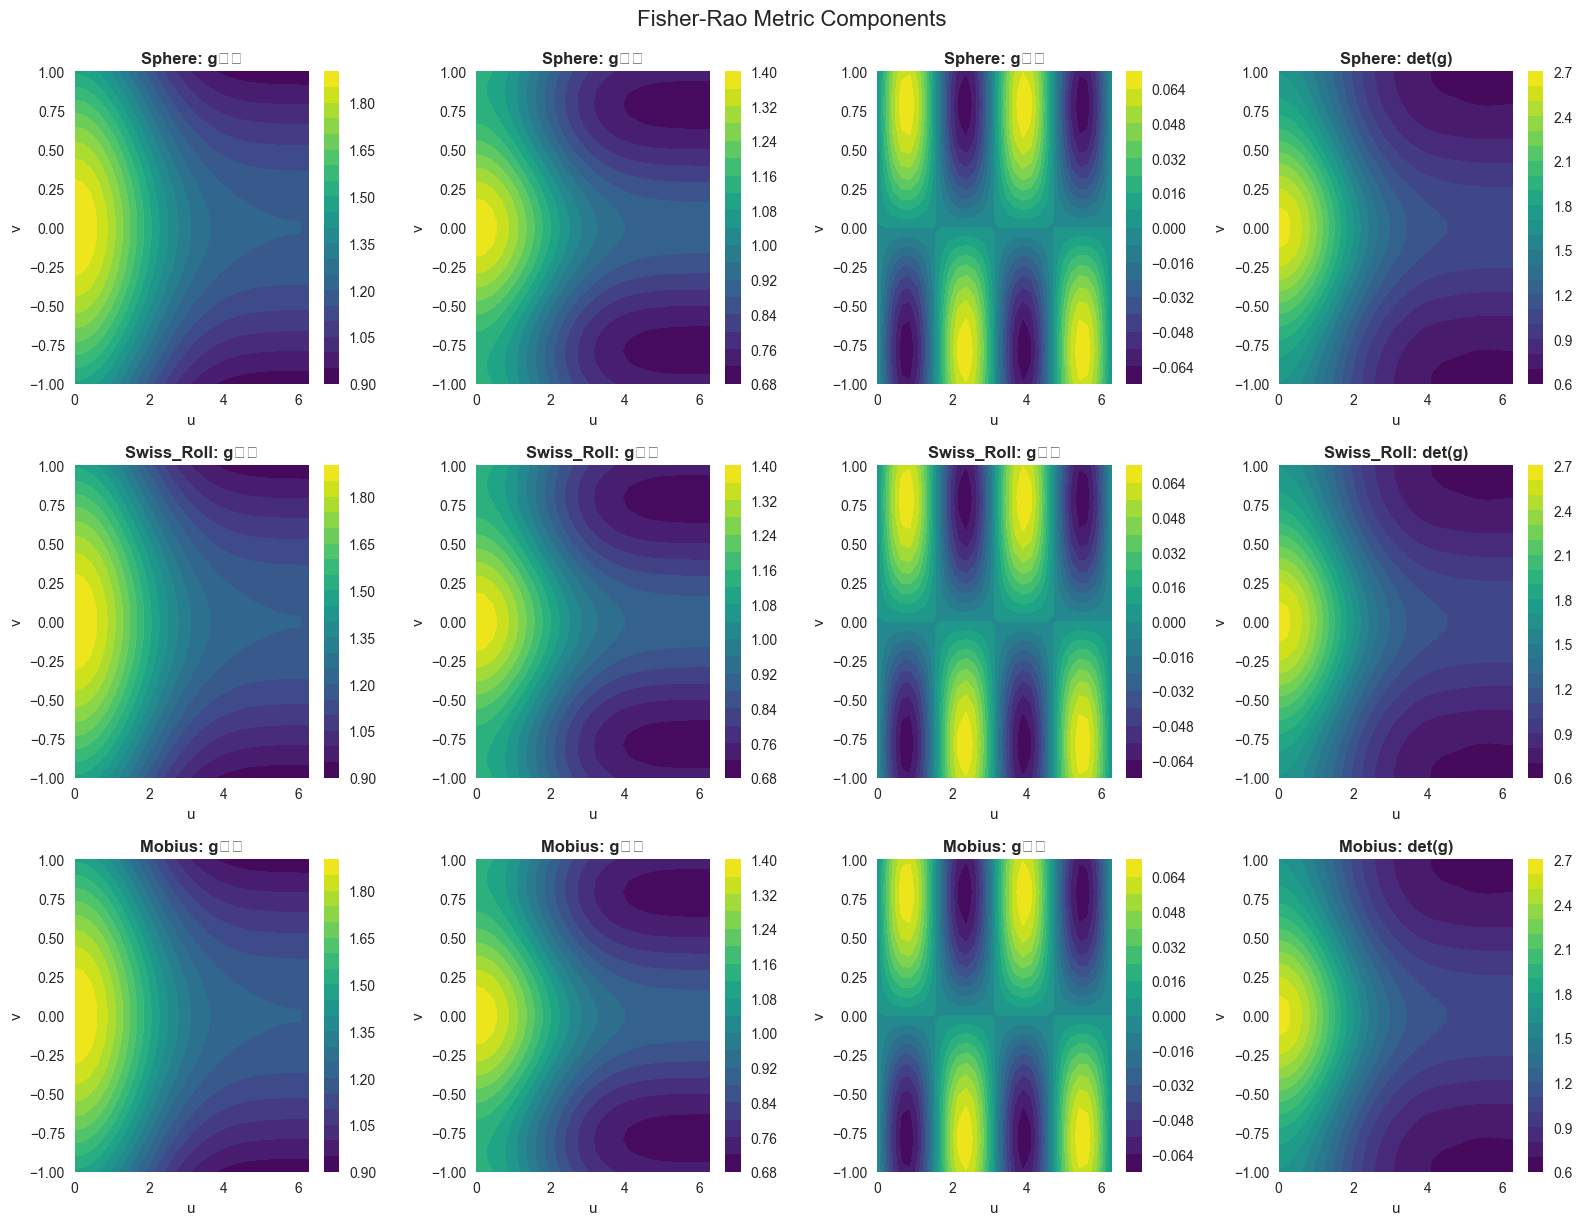

In [7]:
# Visualize metric properties
def visualize_metric(metric_fn, name, n_points=50):
    """Visualize metric tensor components."""
    
    u_vals = np.linspace(0, 2*np.pi, n_points)
    v_vals = np.linspace(-1, 1, n_points)
    U, V = np.meshgrid(u_vals, v_vals)
    
    # Compute metric components
    G11 = np.zeros_like(U)
    G22 = np.zeros_like(U)
    G12 = np.zeros_like(U)
    Det_G = np.zeros_like(U)
    
    for i in range(n_points):
        for j in range(n_points):
            q = np.array([U[i, j], V[i, j]])
            g = metric_fn(q)
            G11[i, j] = g[0, 0]
            G22[i, j] = g[1, 1]
            G12[i, j] = g[0, 1]
            Det_G[i, j] = np.linalg.det(g)
    
    return U, V, G11, G22, G12, Det_G

# Visualize metrics for all datasets
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, (name, metric_data) in enumerate(metrics.items()):
    metric_fn = metric_data['metric_fn']
    U, V, G11, G22, G12, Det_G = visualize_metric(metric_fn, name, n_points=30)
    
    # Plot metric components
    components = [G11, G22, G12, Det_G]
    titles = ['g₁₁', 'g₂₂', 'g₁₂', 'det(g)']
    
    for j, (component, title) in enumerate(zip(components, titles)):
        ax = axes[i, j]
        
        im = ax.contourf(U, V, component, levels=20, cmap='viridis')
        ax.set_title(f'{name.title()}: {title}', fontweight='bold')
        ax.set_xlabel('u')
        ax.set_ylabel('v')
        
        plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.suptitle('Fisher-Rao Metric Components', fontsize=16, y=1.02)
plt.show()

## 5. Topology Selection {#topology}

Explore different quotient topologies and validate metric compatibility.

In [8]:
# Create different topologies for comparison
topologies = {
    'cylinder': create_topology(TopologyType.CYLINDER, w=1.0),
    'mobius': create_topology(TopologyType.MOBIUS, w=1.0),
    'torus': create_topology(TopologyType.TORUS, width=2*np.pi, height=2*np.pi),
    'klein': create_topology(TopologyType.KLEIN, width=2*np.pi, height=2*np.pi),
    'sphere': create_topology(TopologyType.SPHERE, radius=1.0),
    'projective': create_topology(TopologyType.PROJECTIVE)  # Remove radius parameter
}

print("🌐 Created topology atlas:")
print("Topology    | Orientable | Euler χ | Genus | # ID Maps")
print("-" * 55)

for name, topo in topologies.items():
    orientable = "Yes" if topo.orientability.value == "orientable" else "No"
    print(f"{name:<11} | {orientable:<10} | {topo.euler_characteristic:>7} | {topo.genus:>5} | {len(topo.identification_maps()):>9}")

🌐 Created topology atlas:
Topology    | Orientable | Euler χ | Genus | # ID Maps
-------------------------------------------------------
cylinder    | Yes        |       0 |     0 |         1
mobius      | No         |       0 |     0 |         1
torus       | Yes        |       0 |     1 |         2
klein       | No         |       0 |     0 |         2
sphere      | Yes        |       2 |     0 |         3
projective  | No         |       1 |     0 |         2


In [9]:
# Test metric compatibility across topologies
def test_metric_compatibility(metric_fn, topologies):
    """Test metric compatibility across different topologies."""
    
    results = {}
    test_points = [
        np.array([0.5, 0.3]),
        np.array([1.0, 0.7]),
        np.array([1.5, -0.2])
    ]
    
    for topo_name, topo in topologies.items():
        print(f"\n🔍 Testing {topo_name} topology:")
        
        compatible_points = 0
        total_points = len(test_points)
        
        for i, q in enumerate(test_points):
            try:
                is_compatible = topo.metric_compatibility_condition(metric_fn, q)
                if is_compatible:
                    compatible_points += 1
                    status = "✓"
                else:
                    status = "✗"
                print(f"  Point {i+1}: {status} compatible")
            except Exception as e:
                print(f"  Point {i+1}: ⚠️  error - {str(e)[:50]}...")
        
        compatibility_rate = compatible_points / total_points
        results[topo_name] = {
            'compatible_points': compatible_points,
            'total_points': total_points,
            'compatibility_rate': compatibility_rate,
            'orientable': topo.orientability.value == "orientable"
        }
        
        print(f"  Overall: {compatible_points}/{total_points} ({compatibility_rate:.1%}) compatible")
    
    return results

# Test with sphere dataset metric
sphere_metric = metrics['sphere']['metric_fn']
compatibility_results = test_metric_compatibility(sphere_metric, topologies)

print("\n📊 Compatibility Summary:")
print("Topology    | Compatible | Orientable")
print("-" * 35)
for name, result in compatibility_results.items():
    rate = f"{result['compatibility_rate']:.1%}"
    orientable = "Yes" if result['orientable'] else "No"
    print(f"{name:<11} | {rate:>10} | {orientable:>10}")


🔍 Testing cylinder topology:
  Point 1: ✓ compatible
  Point 2: ✓ compatible
  Point 3: ✓ compatible
  Overall: 3/3 (100.0%) compatible

🔍 Testing mobius topology:
  Point 1: ✗ compatible
  Point 2: ✗ compatible
  Point 3: ✗ compatible
  Overall: 0/3 (0.0%) compatible

🔍 Testing torus topology:
  Point 1: ✓ compatible
  Point 2: ✓ compatible
  Point 3: ✗ compatible
  Overall: 2/3 (66.7%) compatible

🔍 Testing klein topology:
  Point 1: ✗ compatible
  Point 2: ✗ compatible
  Point 3: ✗ compatible
  Overall: 0/3 (0.0%) compatible

🔍 Testing sphere topology:
  Point 1: ✓ compatible
  Point 2: ✓ compatible
  Point 3: ✗ compatible
  Overall: 2/3 (66.7%) compatible

🔍 Testing projective topology:
  Point 1: ✓ compatible
  Point 2: ✓ compatible
  Point 3: ✗ compatible
  Overall: 2/3 (66.7%) compatible

📊 Compatibility Summary:
Topology    | Compatible | Orientable
-----------------------------------
cylinder    |     100.0% |        Yes
mobius      |       0.0% |         No
torus       |    

In [10]:
# Comprehensive topology validation
def comprehensive_validation_demo(metric_fn, topology):
    """Demonstrate comprehensive topology validation."""
    
    print(f"🔬 Comprehensive validation for {type(topology).__name__}:")
    
    # For strip-based topologies, we can do full validation
    if hasattr(topology, 'w'):  # Strip-based
        try:
            validation_result = comprehensive_topology_validation(
                g_fn=metric_fn,
                strip=topology,
                tolerance=1e-6
            )
            
            print(f"  ✅ All tests passed: {validation_result['all_passed']}")
            print(f"  📋 Tests run: {', '.join(validation_result['tests_run'])}")
            
            # Show detailed results
            for test_name in validation_result['tests_run']:
                if test_name in validation_result:
                    test_result = validation_result[test_name]
                    if isinstance(test_result, dict):
                        if 'compatible' in test_result:
                            status = "✅" if test_result['compatible'] else "❌"
                            print(f"    {status} {test_name}")
            
            return validation_result
            
        except Exception as e:
            print(f"  ❌ Validation failed: {e}")
            return None
    else:
        print(f"  ⚠️  Full validation not yet implemented for {type(topology).__name__}")
        return None

# Test validation on Möbius and Cylinder
validation_results = {}
for name in ['mobius', 'cylinder']:
    result = comprehensive_validation_demo(sphere_metric, topologies[name])
    if result:
        validation_results[name] = result
    print()

🔬 Comprehensive validation for MobiusBand:
  ✅ All tests passed: False
  📋 Tests run: metric_seam_compatibility
    ❌ metric_seam_compatibility

🔬 Comprehensive validation for Cylinder:
  ✅ All tests passed: False
  📋 Tests run: metric_seam_compatibility
    ❌ metric_seam_compatibility



## 6. Statistical Analysis {#stats}

Perform spectral analysis and compare orientable vs non-orientable surfaces.

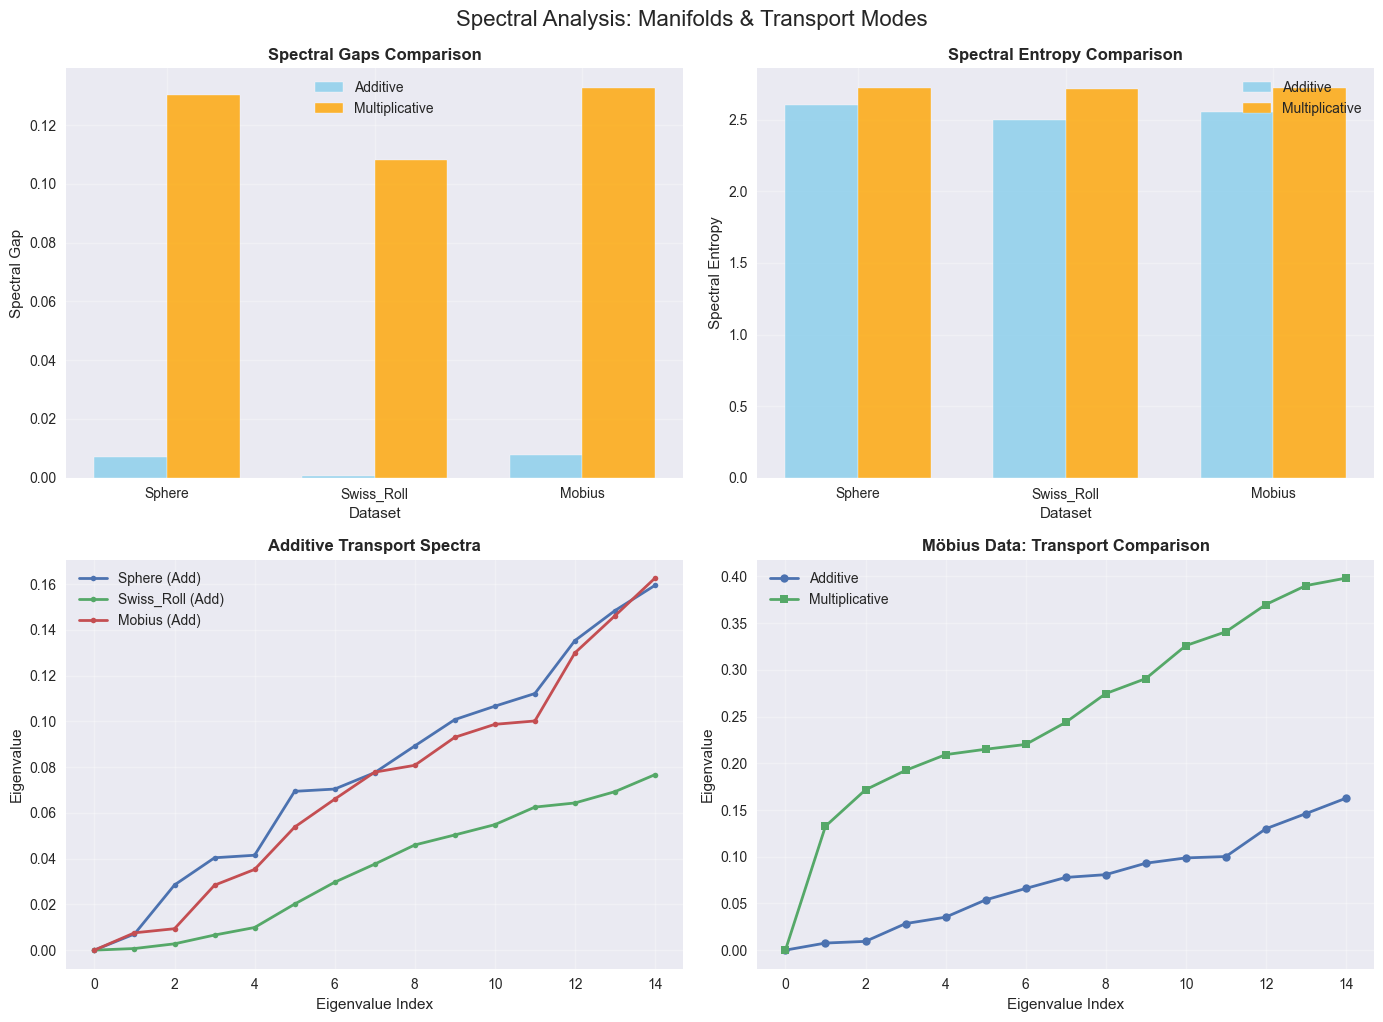


📈 Spectral Statistics Summary:
Dataset     | Transport      | Gap     | Entropy | λ₂      | λ₃
-----------------------------------------------------------------
sphere      | Additive       | 0.0070 | 2.6063  | 0.0070 | 0.0285
sphere      | Multiplicative | 0.1302 | 2.7209  | 0.1302 | 0.1446
swiss_roll  | Additive       | 0.0007 | 2.4996  | 0.0007 | 0.0028
swiss_roll  | Multiplicative | 0.1081 | 2.7125  | 0.1081 | 0.1551
mobius      | Additive       | 0.0076 | 2.5565  | 0.0076 | 0.0094
mobius      | Multiplicative | 0.1326 | 2.7232  | 0.1326 | 0.1717


In [11]:
# Compare spectral properties across datasets and transport modes
def create_spectral_comparison():
    """Create comprehensive spectral comparison."""
    
    comparison_data = []
    
    for dataset_name, results in spectral_results.items():
        for transport in ['add', 'mult']:
            gap = results[f'gap_{transport}']
            entropy = results[f'entropy_{transport}']
            eigenvals = results[f'eigenvals_{transport}'][:10]
            
            comparison_data.append({
                'dataset': dataset_name,
                'transport': 'Additive' if transport == 'add' else 'Multiplicative',
                'gap': gap,
                'entropy': entropy,
                'lambda_2': eigenvals[1],
                'lambda_3': eigenvals[2]
            })
    
    return comparison_data

comparison_data = create_spectral_comparison()

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Spectral gaps comparison
ax1 = axes[0, 0]
datasets = list(spectral_results.keys())
gaps_add = [spectral_results[d]['gap_add'] for d in datasets]
gaps_mult = [spectral_results[d]['gap_mult'] for d in datasets]

x = np.arange(len(datasets))
width = 0.35

ax1.bar(x - width/2, gaps_add, width, label='Additive', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, gaps_mult, width, label='Multiplicative', alpha=0.8, color='orange')

ax1.set_title('Spectral Gaps Comparison', fontweight='bold')
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Spectral Gap')
ax1.set_xticks(x)
ax1.set_xticklabels([d.title() for d in datasets])
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Spectral entropy comparison
ax2 = axes[0, 1]
entropies_add = [spectral_results[d]['entropy_add'] for d in datasets]
entropies_mult = [spectral_results[d]['entropy_mult'] for d in datasets]

ax2.bar(x - width/2, entropies_add, width, label='Additive', alpha=0.8, color='skyblue')
ax2.bar(x + width/2, entropies_mult, width, label='Multiplicative', alpha=0.8, color='orange')

ax2.set_title('Spectral Entropy Comparison', fontweight='bold')
ax2.set_xlabel('Dataset')
ax2.set_ylabel('Spectral Entropy')
ax2.set_xticks(x)
ax2.set_xticklabels([d.title() for d in datasets])
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Full eigenvalue spectra
ax3 = axes[1, 0]
for i, dataset in enumerate(datasets):
    eigenvals = spectral_results[dataset]['eigenvals_add'][:15]
    ax3.plot(eigenvals, 'o-', label=f'{dataset.title()} (Add)', linewidth=2, markersize=4)

ax3.set_title('Additive Transport Spectra', fontweight='bold')
ax3.set_xlabel('Eigenvalue Index')
ax3.set_ylabel('Eigenvalue')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Transport mode comparison for Möbius data
ax4 = axes[1, 1]
mobius_results = spectral_results['mobius']
ax4.plot(mobius_results['eigenvals_add'][:15], 'o-', label='Additive', linewidth=2, markersize=6)
ax4.plot(mobius_results['eigenvals_mult'][:15], 's-', label='Multiplicative', linewidth=2, markersize=6)

ax4.set_title('Möbius Data: Transport Comparison', fontweight='bold')
ax4.set_xlabel('Eigenvalue Index')
ax4.set_ylabel('Eigenvalue')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Spectral Analysis: Manifolds & Transport Modes', fontsize=16, y=1.02)
plt.show()

# Statistical summary
print("\n📈 Spectral Statistics Summary:")
print("Dataset     | Transport      | Gap     | Entropy | λ₂      | λ₃")
print("-" * 65)
for data in comparison_data:
    print(f"{data['dataset']:<11} | {data['transport']:<14} | {data['gap']:.4f} | {data['entropy']:.4f}  | {data['lambda_2']:.4f} | {data['lambda_3']:.4f}")

## 7. Dynamics & Geodesics {#dynamics}

Integrate geodesics on quotient topologies and analyze seam-crossing behavior.

In [12]:
# Geodesic integration demonstration
def integrate_geodesics_demo(metric_fn, metric_grad_fn, topology, n_geodesics=5):
    """Demonstrate geodesic integration with visualization."""
    
    print(f"🌊 Integrating geodesics on {type(topology).__name__}")
    
    # Only implemented for strip-based topologies currently
    if not hasattr(topology, 'w'):
        print(f"  ⚠️  Geodesic integration not yet implemented for {type(topology).__name__}")
        return None
    
    from topology.coords import Strip
    strip = Strip(w=topology.w, period=getattr(topology, 'period', 2*np.pi))
    
    # Generate initial conditions
    rng = np.random.default_rng(42)
    
    geodesic_results = []
    trajectories = []
    
    for i in range(n_geodesics):
        # Random initial position and velocity
        q0 = np.array([
            rng.uniform(0, strip.period*0.8),
            rng.uniform(-strip.w*0.8, strip.w*0.8)
        ])
        v0 = rng.normal(0, 0.3, 2)
        
        try:
            traj_q, traj_v, info = integrate_geodesic(
                q0, v0,
                t_final=8.0,
                dt=0.01,
                g_fn=metric_fn,
                grad_g_fn=metric_grad_fn,
                strip=strip,
                energy_tolerance=1e-2
            )
            
            if info['success']:
                geodesic_results.append(info)
                trajectories.append((traj_q, traj_v, q0, v0))
                
                print(f"  ✓ Geodesic {i+1}: {info['energy_drift']:.2e} drift, {info['seam_crossings']} crossings")
            else:
                print(f"  ✗ Geodesic {i+1}: Failed")
                
        except Exception as e:
            print(f"  ⚠️  Geodesic {i+1}: Error - {str(e)[:50]}...")
    
    return geodesic_results, trajectories, strip

# Run geodesic integration on Möbius band
mobius_metric = metrics['mobius']['metric_fn']
mobius_metric_grad = metrics['mobius']['metric_grad_fn']
mobius_topology = topologies['mobius']

geodesic_results, trajectories, strip = integrate_geodesics_demo(
    mobius_metric, mobius_metric_grad, mobius_topology, n_geodesics=8
)

print(f"\n📊 Geodesic Statistics:")
if geodesic_results:
    print(f"  Successful integrations: {len(geodesic_results)}")
    print(f"  Mean energy drift: {np.mean([r['energy_drift'] for r in geodesic_results]):.2e}")
    print(f"  Total seam crossings: {sum(r['seam_crossings'] for r in geodesic_results)}")
    print(f"  Mean trajectory length: {np.mean([r['trajectory_length'] for r in geodesic_results]):.2f}")

🌊 Integrating geodesics on MobiusBand
  ⚠️  Geodesic 1: Error - Final energy drift 2.64e-01 exceeds tolerance 1.00...
  ✓ Geodesic 2: 5.00e-06 drift, 0 crossings
  ⚠️  Geodesic 3: Error - Final energy drift 6.25e-02 exceeds tolerance 1.00...
  ⚠️  Geodesic 4: Error - Final energy drift 1.20e-02 exceeds tolerance 1.00...
  ✓ Geodesic 5: 2.37e-04 drift, 0 crossings
  ✓ Geodesic 6: 1.29e-04 drift, 0 crossings
  ✓ Geodesic 7: 6.09e-06 drift, 0 crossings
  ✓ Geodesic 8: 2.74e-04 drift, 0 crossings

📊 Geodesic Statistics:
  Successful integrations: 5
  Mean energy drift: 1.30e-04
  Total seam crossings: 0
  Mean trajectory length: 2.70


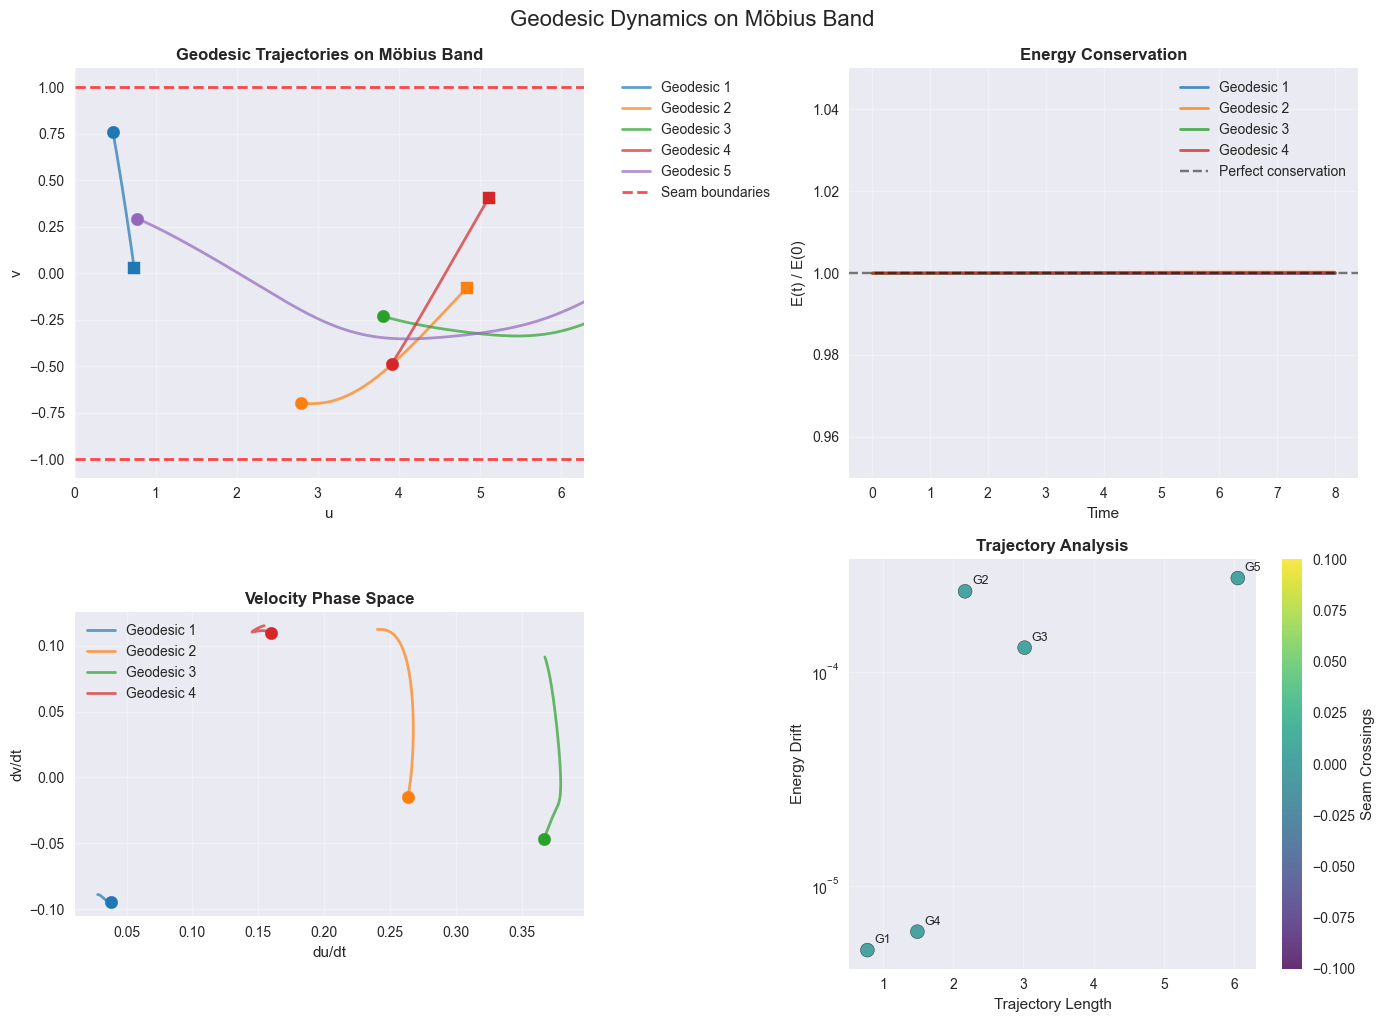


📊 Geodesic Analysis Summary:
  Total geodesics: 5
  Mean energy drift: 1.30e-04
  Max energy drift: 2.74e-04
  Total seam crossings: 0
  Mean trajectory length: 2.70


In [15]:
# Visualize geodesic trajectories
if trajectories:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    # 1. All trajectories on fundamental domain
    ax1 = axes[0, 0]
    
    for i, (traj_q, traj_v, q0, v0) in enumerate(trajectories[:6]):
        color = colors[i % len(colors)]
        ax1.plot(traj_q[:, 0], traj_q[:, 1], '-', color=color, alpha=0.7, linewidth=2, label=f'Geodesic {i+1}')
        ax1.scatter(q0[0], q0[1], color=color, s=80, marker='o', zorder=5)
        ax1.scatter(traj_q[-1, 0], traj_q[-1, 1], color=color, s=80, marker='s', zorder=5)
    
    # Draw seam boundaries
    ax1.axhline(y=strip.w, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Seam boundaries')
    ax1.axhline(y=-strip.w, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    ax1.set_title('Geodesic Trajectories on Möbius Band', fontweight='bold')
    ax1.set_xlabel('u')
    ax1.set_ylabel('v')
    ax1.set_xlim(0, strip.period)
    ax1.set_ylim(-strip.w*1.1, strip.w*1.1)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 2. Energy conservation
    ax2 = axes[0, 1]
    
    for i, result in enumerate(geodesic_results[:4]):
        if 'energy_array' in result and 'time_array' in result:
            energy_normalized = result['energy_array'] / result['initial_energy']
            color = colors[i % len(colors)]
            ax2.plot(result['time_array'], energy_normalized, '-', color=color, 
                    linewidth=2, alpha=0.8, label=f'Geodesic {i+1}')
    
    ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Perfect conservation')
    ax2.set_title('Energy Conservation', fontweight='bold')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('E(t) / E(0)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0.95, 1.05)
    
    # 3. Velocity phase space
    ax3 = axes[1, 0]
    
    for i, (traj_q, traj_v, q0, v0) in enumerate(trajectories[:4]):
        color = colors[i % len(colors)]
        ax3.plot(traj_v[:, 0], traj_v[:, 1], '-', color=color, alpha=0.7, linewidth=2, label=f'Geodesic {i+1}')
        ax3.scatter(v0[0], v0[1], color=color, s=80, marker='o', zorder=5)
    
    ax3.set_title('Velocity Phase Space', fontweight='bold')
    ax3.set_xlabel('du/dt')
    ax3.set_ylabel('dv/dt')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_aspect('equal')
    
    # 4. Seam crossing and energy drift analysis
    ax4 = axes[1, 1]
    
    if geodesic_results:
        seam_crossings = [r['seam_crossings'] for r in geodesic_results]
        energy_drifts = [r['energy_drift'] for r in geodesic_results]
        traj_lengths = [r['trajectory_length'] for r in geodesic_results]
        
        # Scatter plot: trajectory length vs energy drift
        scatter = ax4.scatter(traj_lengths, energy_drifts, c=seam_crossings, 
                             cmap='viridis', s=100, alpha=0.8, edgecolors='black')
        
        for i, (length, drift) in enumerate(zip(traj_lengths, energy_drifts)):
            ax4.annotate(f'G{i+1}', (length, drift), xytext=(5, 5),
                        textcoords='offset points', fontsize=9)
        
        ax4.set_title('Trajectory Analysis', fontweight='bold')
        ax4.set_xlabel('Trajectory Length')
        ax4.set_ylabel('Energy Drift')
        ax4.set_yscale('log')
        cbar = plt.colorbar(scatter, ax=ax4)
        cbar.set_label('Seam Crossings')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Geodesic Dynamics on Möbius Band', fontsize=16, y=1.02)
    plt.show()
    
    # Summary statistics
    print("\n📊 Geodesic Analysis Summary:")
    print(f"  Total geodesics: {len(geodesic_results)}")
    print(f"  Mean energy drift: {np.mean(energy_drifts):.2e}")
    print(f"  Max energy drift: {np.max(energy_drifts):.2e}")
    print(f"  Total seam crossings: {sum(seam_crossings)}")
    print(f"  Mean trajectory length: {np.mean(traj_lengths):.2f}")
else:
    print("⚠️  No successful geodesic trajectories to visualize")